In [120]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import figure, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc("xtick", labelsize=10, top=True,direction="in") #Fontstørrelse på akser, ticks indad
plt.rc("ytick", labelsize=10, right=True, direction="in") #Samme som ovenstående men for y
plt.rc("axes",grid=True,linewidth=1.3) #Slår grid til, og sætter tykkelsen af plot-spine
plt.rc("grid",ls=":",lw=1) #Sætter gridstyle som ":"
plt.rc('font', size=10) #Font og fontstørrelse
plt.rc("figure",figsize=(10,3),dpi=150) #Figurstørrelse og opløsningen på graferne
plt.rc("ytick.major",width=1.3) #Sætter tykkelsen på yticks
plt.rc("xtick.major",width=1.3) #Sætter tykkelsen på xticks

In [131]:
brass_paths_tab = glob.glob("/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_*tab.lis")
brass_paths_tab.sort()
brass_paths = glob.glob("/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_*sum.lis")
brass_paths.sort()
tungsten_paths = glob.glob("/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_*sum.lis")
tungsten_paths.sort()

cool_times_dict = {
    "cool1": 300, "cool2": 900, "cool3": 3600, "cool4": 7200, "cool5": 14400, "cool6": 28800, "cool7": 57600, "cool8": 86400, 
    "cool9": 115200, "cool10": 259200, "cool11": 450, "cool12": 1400, "cool13": 2500, "cool14": 5400, "cool15": 10800,
    "cool16": 360000, "cool17": 21600, "cool18": 43200, "cool19": 150, "cool20": 600, "cool30": 0
}

In [168]:
def get_df_tab(path: str) -> [pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(path)
    cool_time = cool_times_dict[df.iloc[0, 0].replace(" ", "")]
    vals = df.loc[df[df.columns[0]].str.contains("#")].index.values
    df_isotopes = df.iloc[vals[0]+1:vals[1], 0].str.split(expand = True).astype(float)
    df_isomer = df.iloc[vals[1]+1:, 0].str.split(expand = True).astype(float)
    df_isotopes.columns = ["A", "Z", "Bq", "dBq"]
    df_isotopes.columns.name = cool_time
    df_isomer.columns = ["A", "Z", "m", "Bq", "dBq"]
    df_isomer.columns.name = cool_time
    return df_isotopes, df_isomer

def get_df_sum(path: str, extra = False) -> [pd.DataFrame, pd.DataFrame]:
    skipper = 18
    if extra:
        skipper = 194
    df = pd.read_csv(path, skiprows=skipper)
    vals = df.loc[df[df.columns[0]].str.contains("A")].index.values
    for i in range(len(vals)-1):
        if vals[i+1]-vals[i] <= 1:
            continue
        columns = df.iloc[vals[i], 0].split()[3:]
        dff = df.iloc[vals[i]+1:vals[i+1], 0].str.split(expand = True).reset_index().drop("index", axis=1)
        try:
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        except ValueError:
            dff = dff.drop(dff.tail(1).index)
            ff = dff.loc[::2,:len(columns)].set_index(0).astype(float)
        ff.columns = columns
        dd = df.iloc[vals[i]+1:vals[i+1], 0]
        dd = dd.str.replace("+", "", regex=True)
        dd = dd.str.replace("/", "", regex=True)
        dd = dd.str.replace("-", "", regex=True)
        dd = dd.str.replace("%", "", regex=True)
        dd = dd.str.split(expand = True).reset_index().drop("index", axis=1)
        dg = dd.loc[1::2,:len(columns)-1].astype(float)
        dg.columns = columns
        dg.index = ff.index
        if i == 0:
            tot_df = ff
            tot_df_d = dg
        else:
            tot_df = pd.concat([tot_df, ff])
            tot_df_d = pd.concat([tot_df_d, dg])
    name = cool_times_dict[f"cool{int(path.split('_')[4])-20}"]
    tot_df_d.columns.name = name
    tot_df.columns.name = name
    return tot_df, tot_df_d
    
        
    
def plot_img(df: pd.DataFrame, pivot: bool, transpose = False) -> None:
    plt.figure(figsize=(7, 5))
    plt.title(f"Cooling time in sec = {df.columns.name}")
    ax = plt.gca()
    if pivot:
        data = df.pivot_table(index='Z', columns='A', values='Bq')
    else:
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value = df.index[-1]
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()
        last_value2 = df.index[-1]
        aa = pd.DataFrame(index=range(last_value+1), columns =range(last_value2+1))
        aa.iloc[df.columns.values, df.index.values] = df.transpose().values
        data = aa.fillna(0)
    if transpose:
        data = data.transpose()
    im = ax.imshow(data, cmap=cm.gnuplot, norm=LogNorm(vmin=0.1, vmax=10000), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.xlabel("A")
    plt.ylabel("Z")
    plt.colorbar(im, cax=cax)
    plt.show()
    return 


def find_elements(df: pd.DataFrame, threshold: float, cool_in_sec=False) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[df[i] > threshold, i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    print("Cooling time =", df.columns.name if cool_in_sec else df.columns.name/60/60,
          "Seconds" if cool_in_sec else "Hours",
          f"| Threshold = {threshold:.0f}")
    return df_return.sort_values("Bq", ascending=False)


def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    A = np.array([])
    Z = np.array([])
    value = np.array([])
    for i in df.columns:
        temp_df = df.loc[:,i]
        A = np.concatenate((A, temp_df.index.values), axis=None)
        Z = np.concatenate((Z, int(i)*np.ones(len(temp_df.values))), axis=None)
        value = np.concatenate((value, temp_df.values), axis=None)
    
    df_return = pd.DataFrame(A, columns=["A"])
    df_return["Z"] = Z.astype(int)
    df_return["Bq"] = value
    return df_return.fillna(0)


def indv_atom(type_: str, A: str, Z: str) -> list:
    if type_ == "Brass":
        paths = brass_paths
    else:
        paths = tungsten_paths
    
    values = []
    for i in paths:
        if i == "/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_50_sum.lis" \
        or i == "/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_50_sum.lis":
            continue
        try:
            ff1, uncb = get_df_sum(i)
            values.append(ff1.loc[A, Z].sum())
        except Exception as e:
            print("error : ", e)
            values.append(0)
    return values


times_brass = []
tungsten_t = []
sums_brass = []
tungsten_sums = []

for paths, t_path in zip(brass_paths, tungsten_paths):
    try:
        ff1, uncb = get_df_sum(paths)
        sums_brass.append(ff1.sum().sum())
        times_brass.append(cool_times_dict[f"cool{int(paths.split('_')[4])-20}"])
    except:
        print(paths)
    try:
        ft1, unct = get_df_sum(t_path)
        tungsten_sums.append(ft1.sum().sum())
        tungsten_t.append(cool_times_dict[f"cool{int(t_path.split('_')[4])-20}"])
    except:
        print(t_path)
        

def plot_spec(type_: str, A: list, Z: list) -> None:
    
    data = pd.DataFrame(index=tungsten_t)
    for a, z in zip(A, Z):
        data[f"{a}, {z}"] = indv_atom(type_, a, z)
    data = data.sort_index()
    for i in data.columns:
        plt.plot(data.index.values/60/60, data[i].values, label=i)
    plt.title(type_)
    plt.xlabel("Hours")
    plt.ylabel("Bq")
    plt.legend()
    plt.show()
    
    return
    
    



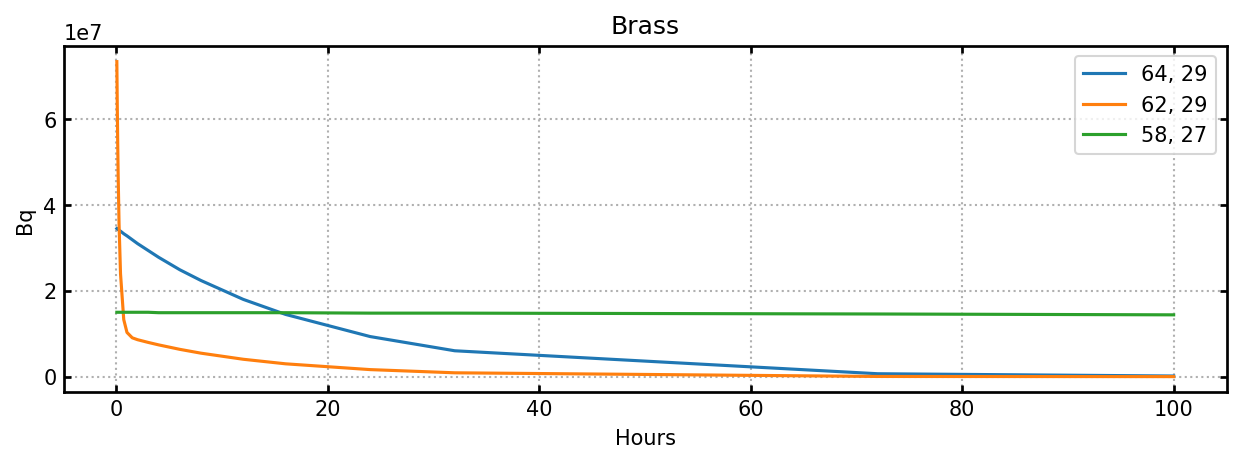

In [169]:
plot_spec("Brass", ["64", "62", "58"], ["29", "29", "27"])

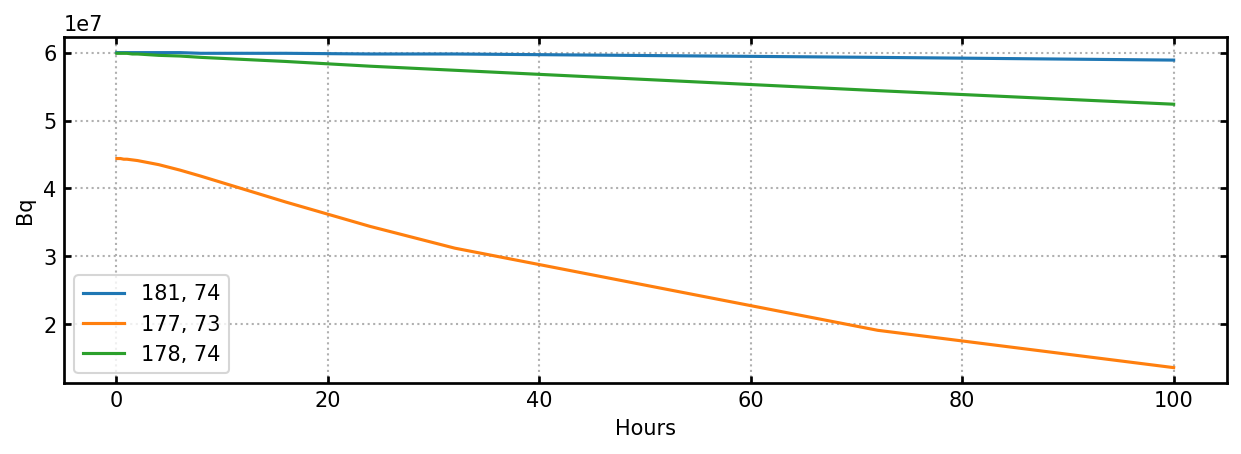

In [163]:
plot_spec("tungsten", ["181", "177", "178"], ["74", "73", "74"])

In [26]:
times_brass = []
tungsten_t = []
sums_brass = []
tungsten_sums = []

for paths, t_path in zip(brass_paths, tungsten_paths):
    try:
        ff1, uncb = get_df_sum(paths)
        sums_brass.append(ff1.sum().sum())
        times_brass.append(cool_times_dict[f"cool{int(paths.split('_')[4])-20}"])
    except:
        print(paths)
    try:
        ft1, unct = get_df_sum(t_path)
        tungsten_sums.append(ft1.sum().sum())
        tungsten_t.append(cool_times_dict[f"cool{int(t_path.split('_')[4])-20}"])
    except:
        print(t_path)

/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_50_sum.lis
/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_50_sum.lis


In [97]:
tot_df_tungsten, extra = get_df_sum(tungsten_paths[0])
tot_df_tungsten = sort_df(tot_df_tungsten)

for i in range(1, len(tungsten_paths)):
    path = tungsten_paths[i]
    if path == "/home/msd/AU/fluka_simulations/Full_Sim/Tungsten/tungsten_totsim_50_sum.lis":
        continue
    df, extra = get_df_sum(path)
    tot_df_tungsten = pd.concat([tot_df_tungsten, sort_df(df)], join="inner")
    
df_sums_tungsten = pd.pivot_table(tot_df_tungsten, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
df_sums_tungsten = df_sums_tungsten.sort_values(by="Bq", ascending=False)
    
tot_df_brass, extra = get_df_sum(brass_paths[0])
tot_df_brass = sort_df(tot_df_brass)

for i in range(1, len(brass_paths)):
    path = brass_paths[i]
    if path == "/home/msd/AU/fluka_simulations/Full_Sim/Brass/brass_totsim_50_sum.lis":
        continue
    df, extra = get_df_sum(path)
    tot_df_brass = pd.concat([tot_df_brass, sort_df(df)], join="inner")
    
df_sums_brass = pd.pivot_table(tot_df_brass, index=["A", "Z"], values=["Bq"], aggfunc=np.sum)
df_sums_brass = df_sums_brass.sort_values(by="Bq", ascending=False)   
    

hello
hello


#### Halflife:  (181, 74) = 121.2 days | (178, 74) = 21.6 days | (177, 73) = 56.56 hours


(                  Bq
 A   Z               
 181 74  1.197500e+09
 178 74  1.176800e+09
 177 73  7.913000e+08
 181 75  7.631200e+08
 179 74  5.685671e+08
 185 74  4.857000e+08
 183 75  4.380000e+08
 177 74  4.172160e+08
 187 74  3.838400e+08
 176 73  3.626630e+08,
 <Axes: xlabel='A,Z'>)

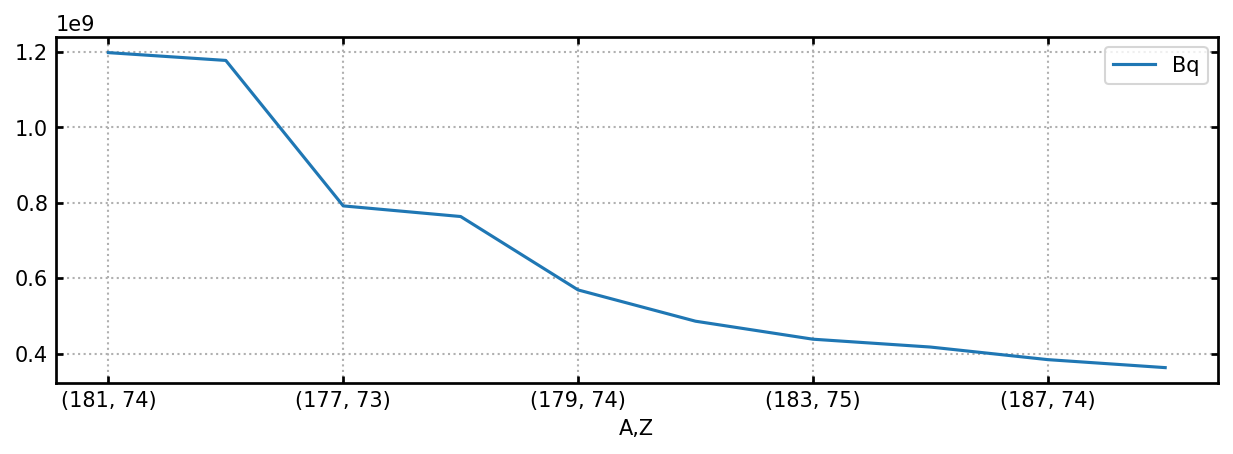

In [100]:
df_sums_tungsten[:10], df_sums_tungsten[:10].plot()

#### Halflife:  (64, 29) = 12.7 hours | (62, 29) = 9.67 min | (58, 27) = 70.86 days


(                  Bq
 A   Z               
 64  29  4.877980e+08
 61  29  4.254231e+08
 62  29  3.752952e+08
 58  27  2.981000e+08
 65  30  2.138000e+08
 63  30  1.717153e+08
 62  30  1.299983e+08
 57  27  1.246500e+08
 203 82  1.038100e+08
 7   4   1.021600e+08,
 <Axes: xlabel='A,Z'>)

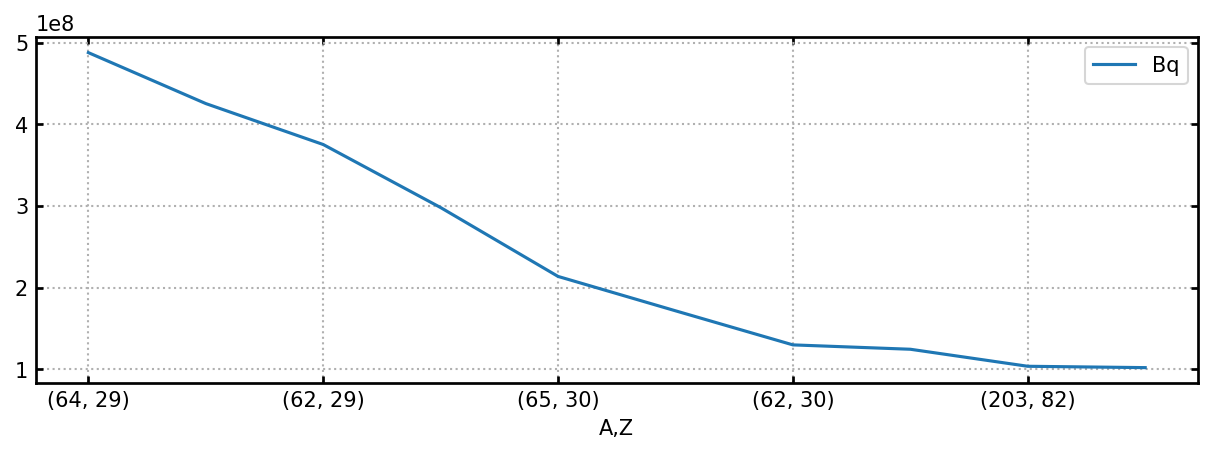

In [101]:
df_sums_brass[:10], df_sums_brass[:10].plot()

In [94]:
ff1, ff2 = get_df_sum(tungsten_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 14095851


,A,Z,Bq
1,181,74,58900000.0
2,178,74,52400000.0
0,185,74,23500000.0
3,183,75,21200000.0


In [23]:
ff1, ff2 = get_df_sum(brass_paths[15])
find_elements(ff1, ff1.max().mean()*10)

Cooling time = 100.0 Hours | Threshold = 5366873


,A,Z,Bq
0,58,27,14400000.0
2,65,30,10600000.0
1,57,27,6180000.0


In [24]:
ff1, ff2 = get_df_sum(brass_paths[18])
find_elements(ff1, ff1.max().mean()*10, True)

Cooling time = 150 Seconds | Threshold = 24556121


,A,Z,Bq
1,62,29,73400000.0
2,61,29,40400000.0
0,64,29,34500000.0
3,63,30,26600000.0


In [25]:
ff1, ff2 = get_df_sum(tungsten_paths[18])
find_elements(ff1, ff1.max().mean()*10, True)

Cooling time = 150 Seconds | Threshold = 29642340


,A,Z,Bq
2,179,74,77300000.0
1,181,74,60000000.0
3,178,74,59900000.0
5,181,75,50000000.0
6,179,75,46900000.0
0,177,73,44400000.0
4,177,74,42600000.0
7,178,75,31400000.0


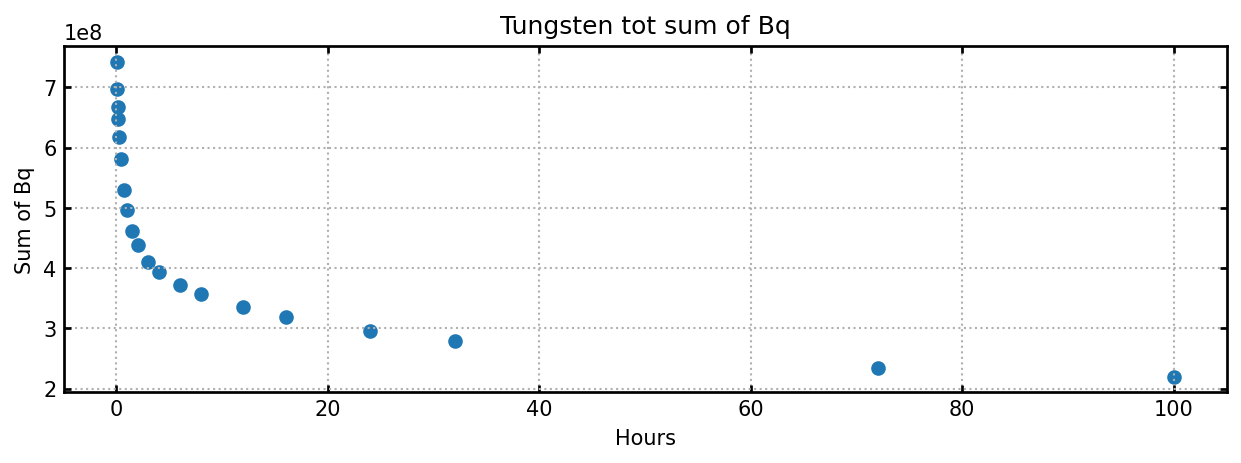

In [10]:
plt.scatter(np.array(tungsten_t)/60/60, tungsten_sums)
plt.title("Tungsten tot sum of Bq")
plt.xlabel("Hours")
plt.ylabel("Sum of Bq")
plt.show()

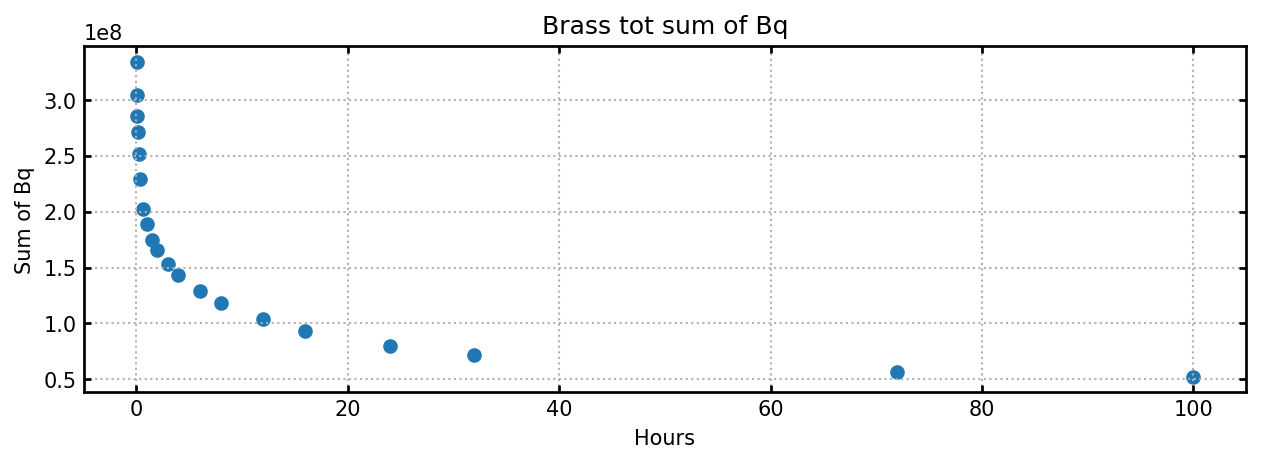

In [11]:
plt.scatter(np.array(times_brass)/60/60, sums_brass)
plt.title("Brass tot sum of Bq")
plt.xlabel("Hours")
plt.ylabel("Sum of Bq")
plt.show()
# exp fit half life overall 

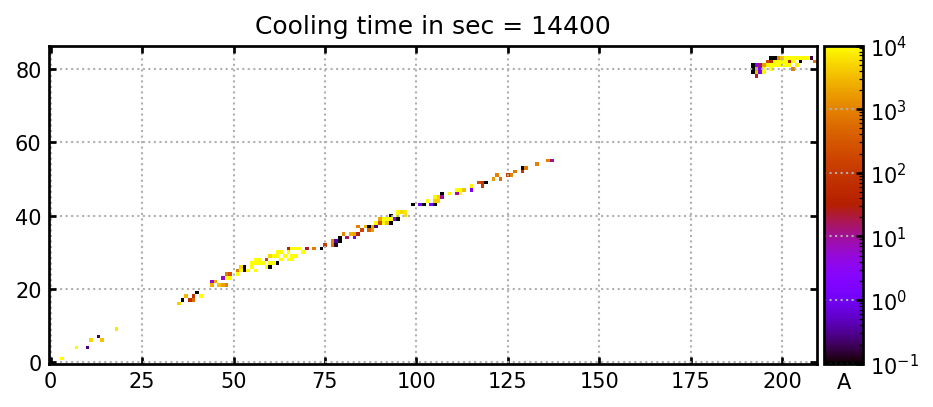

In [12]:
ff1, ff2 = get_df_sum(brass_paths[4])
plot_img(ff1, False, True)

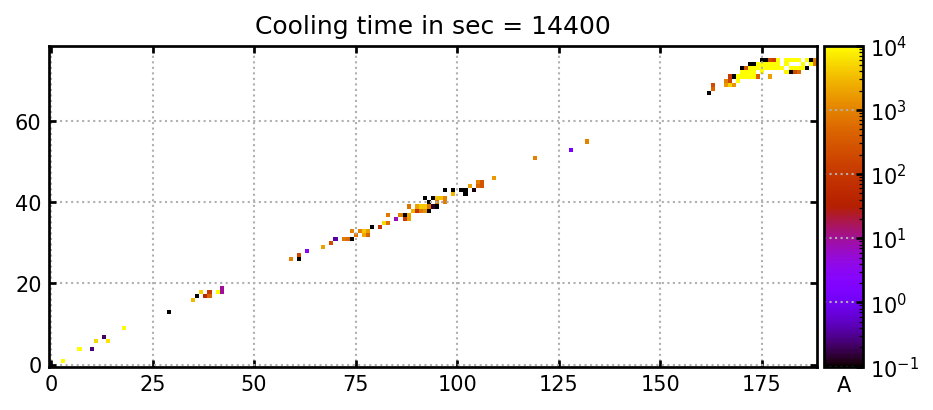

In [13]:
ff1, ff2 = get_df_sum(tungsten_paths[4])
plot_img(ff1, False, True)